In [1]:
# use conda activate trading

#!pip install numpy
#!pip install pandas
#!pip install matplotlib
#!pip install scikit-learn
#!pip install Keras
#!pip install python-binance
#!pip install seaborn
#!pip3 install tensorflow
#!pip3 install --upgrade numpy==1.23.0

                                              0.0/15.0 MB ? eta -:--:--
                                              0.0/15.0 MB ? eta -:--:--
                                              0.0/15.0 MB ? eta -:--:--
                                              0.0/15.0 MB ? eta -:--:--
                                              0.0/15.0 MB ? eta -:--:--
                                             0.0/15.0 MB 109.5 kB/s eta 0:02:17
                                             0.0/15.0 MB 122.9 kB/s eta 0:02:02
                                             0.0/15.0 MB 122.9 kB/s eta 0:02:02
                                             0.1/15.0 MB 156.1 kB/s eta 0:01:36
                                             0.1/15.0 MB 191.1 kB/s eta 0:01:19
                                             0.1/15.0 MB 187.5 kB/s eta 0:01:20
                                             0.1/15.0 MB 211.6 kB/s eta 0:01:11
                                             0.1/15.0 MB 250.7 kB/s eta 0:01:00


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime
from datetime import datetime
from sklearn.metrics import mean_squared_error
import tensorflow


%matplotlib inline
plt.style.use('fivethirtyeight')          #Used for replicating graph styles from fivethirtyeight.com

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Activation
from tensorflow.python.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential

from binance.client import Client

In [24]:
api_key = "lJYkTkITAnS1W4HYRlHoS0XXhGQmn5KtIvI3lodNzVCm33tBGZYNtJ6dVZYhziiu"
secret_key="wmFfcX5H8sdqJjc5gXgFMYSlKgtBLkclRzRphUTFV6aPEkHJVODm0JAI6i9sMcxu"


client = Client(api_key,secret_key)

candles = client.get_klines(symbol='BTCUSDT',interval = Client.KLINE_INTERVAL_1MINUTE);

In [25]:
len(candles)

500

In [26]:
candles[499]      #time-open-high-low-close-volume-close_time

[1687170180000,
 '26413.36000000',
 '26413.36000000',
 '26412.26000000',
 '26412.26000000',
 '2.53539000',
 1687170239999,
 '66967.74783780',
 97,
 '0.69861000',
 '18452.55778960',
 '0']

In [27]:
#Fetching closing prices from candlesticks data

price = np.array([float(candles[i][4]) for i in range(500)])

In [28]:
#Fetching opening time from candlesticks data
time = np.array([int(candles[i][0]) for i in range(500)])

#Converting time to HH:MM:SS format
t = np.array([datetime.fromtimestamp(time[i]/1000).strftime('%H:%M:%S') for i in range(500)])

In [29]:
price.shape

(500,)

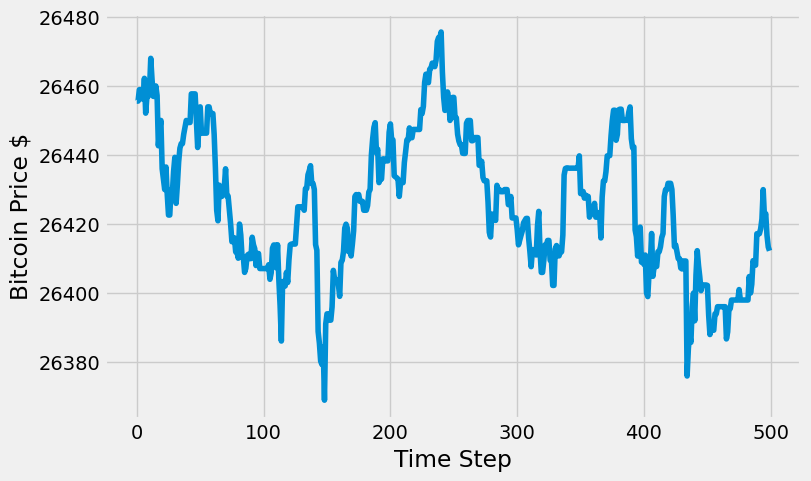

In [30]:
plt.figure(figsize=(8,5))
plt.xlabel("Time Step")
plt.ylabel("Bitcoin Price $")
plt.plot(price)

In [31]:
#Putting this data into a dataframe
timeframe = pd.DataFrame({'Time':t,'Price $BTC':price})
timeframe  #minute by minute price

,Time,Price $BTC
0,22:04:00,26455.61
1,22:05:00,26455.61
2,22:06:00,26458.91
3,22:07:00,26458.91
4,22:08:00,26456.26
...,...,...
495,06:19:00,26422.00
496,06:20:00,26423.01
497,06:21:00,26416.72
498,06:22:00,26413.35


In [32]:
price = price.reshape(500,1)

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [34]:
scaler.fit(price[:374])

StandardScaler()

In [35]:
price = scaler.transform(price)

In [36]:
#Putting the standardized data into dataframe according to input and target(output) columns for model training
df = pd.DataFrame(price.reshape(100,5),columns = ['First','Second','Third','Fourth','Target'])

In [37]:
df.head()

,First,Second,Third,Fourth,Target
0,1.359044,1.359044,1.533933,1.533933,1.393492
1,1.392962,1.708293,1.174085,1.433769,1.432179
2,1.522274,2.015144,1.696633,1.431650,1.431650
3,1.591170,1.444899,0.673796,0.912281,1.061732
4,0.320307,0.158137,0.001797,0.347336,-0.071869


In [38]:
#Split train and test data

x_train = df.iloc[:74,:4]
y_train = df.iloc[:74,-1]

x_test = df.iloc[75:99,:4]
y_test = df.iloc[75:99,-1]

In [82]:
x_train = np.array(x_train).reshape(74,1,4)
y_train = np.array(y_train)
x_test = np.array(x_test).reshape(24,1,4)
y_test = np.array(y_test)

In [40]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [83]:
x_train.shape, x_test.shape

((74, 1, 4), (24, 1, 4))

In [84]:
#Calibrating and initializing the prediction model

model = Sequential()

model.add(LSTM(32,return_sequences=True,input_shape=(1,4)))
model.add(LSTM(16,return_sequences=False))
model.add(Dense(16,activation='linear'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mse',optimizer='rmsprop')

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 1, 32)             4736      
                                                                 
 lstm_12 (LSTM)              (None, 16)                3136      
                                                                 
 module_wrapper_5 (ModuleWra  (None, 16)               272       
 pper)                                                           
                                                                 
 module_wrapper_6 (ModuleWra  (None, 1)                17        
 pper)                                                           
                                                                 
Total params: 8,161
Trainable params: 8,161
Non-trainable params: 0
_________________________________________________________________


In [85]:
model.fit(x_train,y_train,batch_size=5,epochs=300)

Epoch 1/300
15/15 [==============================] - 3s 4ms/step - loss: 0.9717
Epoch 2/300
15/15 [==============================] - 0s 4ms/step - loss: 0.8063
Epoch 3/300
15/15 [==============================] - 0s 4ms/step - loss: 0.5984
Epoch 4/300
15/15 [==============================] - 0s 4ms/step - loss: 0.3883
Epoch 5/300
15/15 [==============================] - 0s 4ms/step - loss: 0.2217
Epoch 6/300
15/15 [==============================] - 0s 3ms/step - loss: 0.1437
Epoch 7/300
15/15 [==============================] - 0s 4ms/step - loss: 0.1270
Epoch 8/300
15/15 [==============================] - 0s 4ms/step - loss: 0.1195
Epoch 9/300
15/15 [==============================] - 0s 3ms/step - loss: 0.1141
Epoch 10/300
15/15 [==============================] - 0s 3ms/step - loss: 0.1078
Epoch 11/300
15/15 [==============================] - 0s 3ms/step - loss: 0.1027
Epoch 12/300
15/15 [==============================] - 0s 3ms/step - loss: 0.0964
Epoch 13/300
15/15 [=================

In [86]:
y_pred = model.predict(x_test)

1/1 [==============================] - 1s 627ms/step


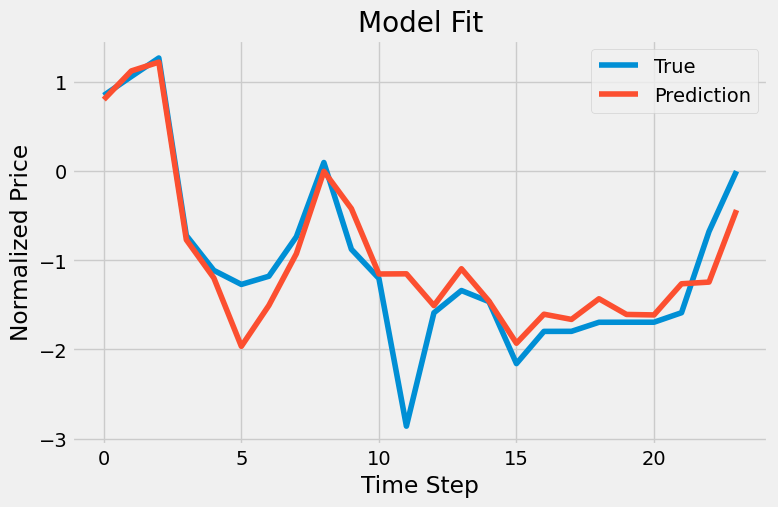

In [87]:
#Plotting the prediction vs actual graph for scaled data
plt.figure(figsize = [8,5])
plt.title('Model Fit')
plt.xlabel('Time Step')
plt.ylabel('Normalized Price')
plt.plot(y_test,label = "True")
plt.plot(y_pred,label="Prediction")
plt.legend()
plt.show()

In [88]:
y_test = y_test.reshape(24,1)

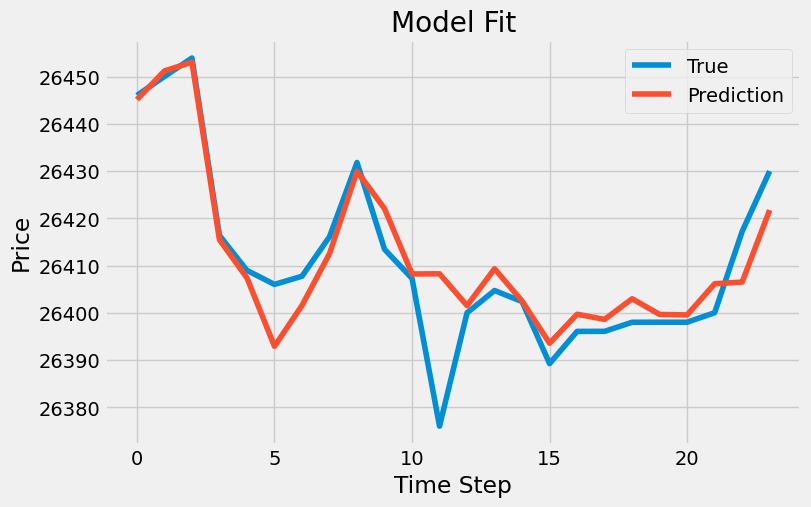

In [89]:
#Plotting the prediction vs actual graph for scaled data
plt.figure(figsize = [8,5])
plt.title('Model Fit')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.plot(scaler.inverse_transform(y_test),label = "True")
plt.plot(scaler.inverse_transform(y_pred),label="Prediction")
plt.legend()
plt.show()

In [90]:
testScore = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test),scaler.inverse_transform(y_pred)))
print('Test Score : %2f RMSE' % (testScore))

Test Score : 8.312846 RMSE


In [68]:
from sklearn.metrics import r2_score

In [69]:
print('RSquared : ', '{:.2%}'.format(r2_score(y_test,y_pred)))

RSquared :  79.30%


In [29]:
model.save("Bitcoin_model.h5")